**Google Colab is a cloud server of ubuntu system(Running linux commands)**

Connect to google drive of yourself

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

"ObjectDetectionAPI/" is a folder created by myself

In [ ]:
!pwd
%cd /content/drive/My Drive/ObjectDetectionAPI
!ls

# **Download Only(MobileNetV1_SSDLite)**

"MobileNet_SSDSeries/MobileNetV1_SSDLite/" is a folder created by myself

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV1_SSDLite

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz
!tar xf ssd_mobilenet_v1_coco_2018_01_28.tar.gz

# **Download Only(MobileNetV2_SSDLite)**

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV2_SSDLite

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
!tar xf ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz

# **Need Object Detection API (MobileNetV3_SSDLite Large / Small)**




「*注意：」MobileNetV3_SSDLite官网上的训练结果无法直接使用，需要先导出frozen.pb 


# 1.Setup Station(API preparation stage)

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI

Based on [tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1.md)

## Install（Corresponding associated dependency package installation）

1.   Download the tensorflow/models repository
2.   COCO API installation
3.   Add Libraries to PYTHONPATH
4.   Protobuf Compilation
5.   Install object_detection package







**1. Download the tensorflow/models repository**(object detection API library) 

Get tensorflow/models or cd to parent directory of the repository.（get model repository）

In [ ]:
import os
import pathlib

# 当前路径：/content/drive/My Drive/ObjectDetectionAPI
print(pathlib.Path.cwd())
# 分割路径（元组）：('/', 'content', 'drive', 'My Drive', 'ObjectDetectionAPI')
print(pathlib.Path.cwd().parts)
# 当前路径下是否存在models文件夹
print(pathlib.Path('models'))

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    # 切换到当前目录的上一级目录
    os.chdir('..')
# 如果不存在则下载获取model库
elif not pathlib.Path('models').exists():
  print("Download models!!")
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
!ls
!pwd

**2. COCO API installation**（COCO dataset operation library）



In [ ]:
!pip install pycocotools

**3. Add Libraries to PYTHONPATH**

The tensorflow/models/research/ and slim directories should be appended to PYTHONPATH

In [ ]:
# From tensorflow/models/research/（linux方式添加环境变量）
# !export PYTHONPATH=$PYTHONPATH:/content/models/research:/content/models/research/slim

magic command type to set environment variable：[%set_env](https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=%25set_env)

1.   % - is provided by the IPython kernel-"magic commands"
2.   ! -  is provided by Jupyter(linux command)



In [ ]:
# Practical Switching Directory（!cd can't realize）
%cd ./models/research/
# 添加两个python寻找路径
%set_env PYTHONPATH=/content/drive/My Drive/ObjectDetectionAPI/models/research:/content/drive/My Drive/ObjectDetectionAPI/models/research/slim

In [ ]:
import sys
print(sys.path)

In [ ]:
!echo $PYTHONPATH

**4. Protobuf Compilation**

The Tensorflow Object Detection API uses Protobufs to configure model and training parameters. Before the framework can be used, the Protobuf libraries must be compiled. 

In [ ]:
!pwd # From 'tensorflow/models/research/' directory

In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

**5. Install the object_detection package**

Execute the setup.py file in the current directory （/content/models/research/setup.py）

In [ ]:
# 安装所需依赖包（Pillow, Matplotlib, Cython...）
#!pip install .

Some of the functions defined in tensorflow/models/research/slim has been moved to tf-slim: [tf_slim install](https://github.com/google-research/tf-slim)

In [ ]:
!pip install --upgrade tf_slim

## Import(导入需要的包)

[Reference](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb)

In [ ]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Make sure tensorflow is 1.* version（now the default import is 2.*）

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

Import the object detection module.

In [ ]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# 2.Model preparation

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
# dictionary(传入vis_util.visualize_boxes_and_labels_on_image_array（）)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

For the sake of simplicity we will test on 2 images:

In [ ]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (24, 24)

# 3.Detection

## Function(imageProcess, inference, drawResult..)

In [ ]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, axis=0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [ ]:
def run_detection(path_to_frozen_graph, title):
  detection_graph = tf.Graph()
  with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path_to_frozen_graph, 'rb') as fid:
      serialized_graph = fid.read()
      od_graph_def.ParseFromString(serialized_graph)
      tf.import_graph_def(od_graph_def, name='')

  plt.figure(figsize=IMAGE_SIZE)
  
  for i, image_path in enumerate(TEST_IMAGE_PATHS):
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)

    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    print('detected_class_index:',output_dict['detection_classes'])
    print('detected_class_scores:',output_dict['detection_scores'])
    # Visualization of the results of a detection.
    # min_score_thresh=.5
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)

    plt.subplot(3, 3, i+1)
    plt.imshow(image_np)
    plt.title(title)

Image online display

In [ ]:
%matplotlib inline

In [ ]:
!pwd

## Export MobileNetV3_Large_SSDLite model and run inference.

Download checkpoint from [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md) and exporting a trained model.

copy link(download URL)

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Large_SSDLite

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
!tar xf ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz

Transformate checkPoint to frozen.pb


In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/models/research

In [ ]:
!python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Large_SSDLite/ssd_mobilenet_v3_large_coco_2020_01_14/pipeline.config \
    --trained_checkpoint_prefix=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Large_SSDLite/ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt \
    --output_directory=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Large_SSDLite/exported_MobileNet3_Large

current path:（/content/drive/My Drive/ObjectDetectionAPI/models/research）

In [ ]:
!pwd

exported result: file tree

In [ ]:
!ls -al /content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Large_SSDLite/exported_MobileNet3_Large

## Run Inference(MobileNetV3_Large test)

Inference using frozen_inference_graph.pb.

In [ ]:
#run_detection(os.path.join('export_ssd_mobileDet_CPU', 'frozen_inference_graph.pb'), 'ssdLite_mobileNetV3_Large')

detected_class_index: [18 18 18 18  1  1 18 18 19 18  1  1 51  1  1  1  1 62 51 21 55 51  1 51
 37  1 21  1 19 62 15  1  1  3 62 55 62 57  1  1 19 21 19  1 18  1 57  3
 31 63 62 51 18  1  1  1 18 37 32 51  1 31 27 62 55 18 27 40 47 51 18 57
  8 21 62 31  1  1 55  3 37 62 21 63 47 67  1 33 63 62 18 57 18 18 77  9
  1 18  3 18]
detected_class_scores: [0.7684052  0.6994863  0.62656724 0.5269837  0.5116876  0.4871581
 0.3880955  0.3806023  0.33441347 0.33377945 0.32990834 0.3249811
 0.3190791  0.31623918 0.30893132 0.30630934 0.306179   0.29554468
 0.29107928 0.28030872 0.25846952 0.25285575 0.25207984 0.25198442
 0.2519049  0.24703333 0.23879352 0.23575935 0.23181236 0.22944409
 0.22890493 0.2280685  0.22754753 0.2252625  0.21929443 0.21908203
 0.21789482 0.20845938 0.20582977 0.20580935 0.20554432 0.20486411
 0.2029587  0.19886601 0.19779855 0.19736865 0.19707611 0.19656721
 0.19529644 0.19454208 0.19437742 0.19080797 0.18978018 0.18892151
 0.1871084  0.1837849  0.18326145 0.18235406 0.1

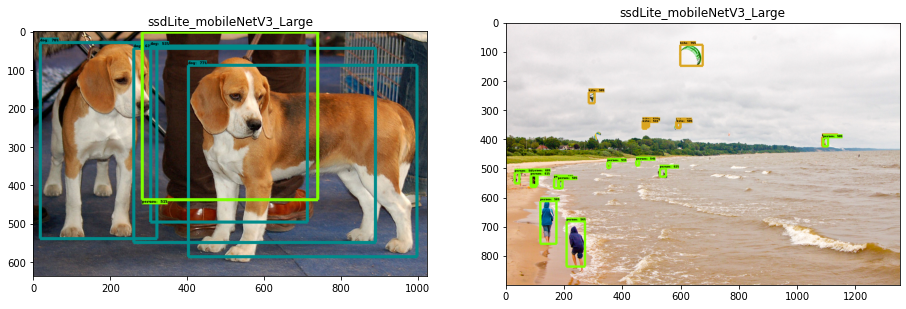

In [27]:
run_detection(os.path.join('/content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Large_SSDLite/exported_MobileNet3_Large/frozen_inference_graph.pb'), 'ssdLite_mobileNetV3_Large')

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Large_SSDLite

In [ ]:
!ls

In [ ]:
!zip -q -r exported_MobileNet3_Large.zip exported_MobileNet3_Large

## Export SSD MobileNet v3 small model and run inference.

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Small_SSDLite

In [ ]:
# 下载模型压缩文件
!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_small_coco_2020_01_14.tar.gz
# 解压缩
!tar xf ssd_mobilenet_v3_small_coco_2020_01_14.tar.gz

***From the trained model.ckpt(checkpoint)file get the frozen model(export_inference_graph.py)***

In [ ]:
!pwd

In [ ]:
%cd /content/drive/My\ Drive/ObjectDetectionAPI/models/research

In [ ]:
!python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Small_SSDLite/ssd_mobilenet_v3_small_coco_2020_01_14/pipeline.config \
    --trained_checkpoint_prefix=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Small_SSDLite/ssd_mobilenet_v3_small_coco_2020_01_14/model.ckpt \
    --output_directory=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Small_SSDLite/exported_MobileNetV3_Small

In [ ]:
!ls -al /content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Small_SSDLite/exported_MobileNetV3_Small

## Run Inferenc(MobileNetV3_Small test)

Inference using frozen_inference_graph.pb.

detected_class_index: [18 18 62 62 21  1  1  1  1 62  1  1 18  1 62  1  1 21  1  1  1 18  1  1
  1  1 18  1  1  1 18 19 62 19 62  1  1 63  1 18  1  1 18 62  1  1 18 62
 62 62  1 62 62 15 62 62  1  1 63 17  1  1 62 62 67 62 62 17 84 62 18  1
 18 27  1 62  1  1 62 18 18 21  1 62 18 63 62 62 84  3  1  1  3  1 62 18
 18 62  1  1]
detected_class_scores: [0.70400906 0.6525326  0.57694757 0.5470198  0.42435485 0.41392452
 0.4031236  0.3920386  0.39071685 0.36005604 0.33978814 0.3317793
 0.32825595 0.32049733 0.30381995 0.30066273 0.29641068 0.29350275
 0.2894003  0.2881651  0.2871672  0.2842402  0.28183445 0.2783373
 0.26831916 0.26673692 0.26534116 0.26277417 0.2608275  0.24575767
 0.24154049 0.2408284  0.24062675 0.2354686  0.23106682 0.23042402
 0.22972295 0.22750598 0.22384903 0.2231116  0.22091019 0.21956474
 0.21554661 0.21188784 0.20967057 0.20965052 0.20830959 0.20748553
 0.20622045 0.20576274 0.20373777 0.20104969 0.20057166 0.2002047
 0.19856188 0.19817159 0.19740546 0.19696826 0.19

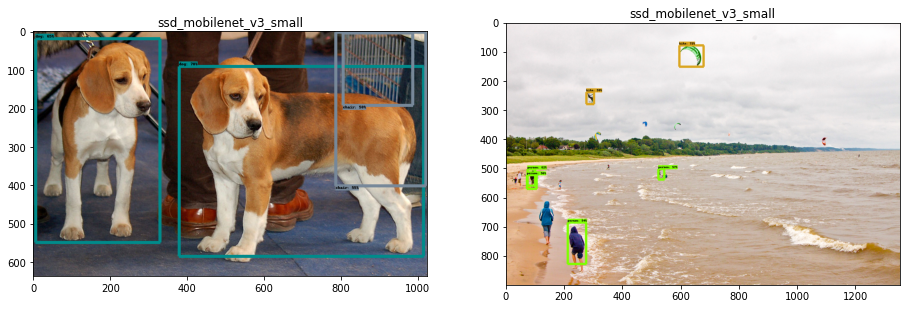

In [28]:
run_detection(os.path.join('/content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Small_SSDLite/exported_MobileNetV3_Small/frozen_inference_graph.pb'), 'ssd_mobilenet_v3_small')

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileNetV3_Small_SSDLite

In [ ]:
!ls

In [ ]:
!zip -q -r exported_MobileNetV3_Small.zip exported_MobileNetV3_Small

## Export MobileDet_SSDLite_CPU model and run inference.

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileDet_SSDLite_CPU

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_cpu_320x320_coco_2020_05_19.tar.gz

In [ ]:
!tar xf ssdlite_mobiledet_cpu_320x320_coco_2020_05_19.tar.gz

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/models/research

In [ ]:
!python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileDet_SSDLite_CPU/ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/pipeline.config \
    --trained_checkpoint_prefix=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileDet_SSDLite_CPU/ssdlite_mobiledet_cpu_320x320_coco_2020_05_19/model.ckpt-400000 \
    --output_directory=/content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileDet_SSDLite_CPU/exported_MobileDet_CPU

In [ ]:
!ls -al /content/drive/My\ Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileDet_SSDLite_CPU/exported_MobileDet_CPU

## Run Inference(MobileDet test)

detected_class_index: [18 18  1 18  1 18  1  1  1  3 18  1  2  1 18  1 63  1 15  1  3  1  1  1
  8 62 18  1  1 65  1 27  1 62  1 18 62  1 17  1 18  1  1  1 64 18 19  1
  3 18  8 23  2 18  8 15 31  1  1  1 64 18 64  1 19 18  6 63  6  1  1  1
 18 17  1 21  1 21  3 64  1 62 18  3  1 19  1  1  2 15 63  1  3 15 62  1
 64 27  1  9]
detected_class_scores: [0.7630098  0.7122336  0.6035962  0.52057016 0.48990178 0.4287857
 0.35614443 0.34366557 0.3028661  0.29625082 0.2654692  0.25890985
 0.25381708 0.2528842  0.21891853 0.21486098 0.21261802 0.2120204
 0.20827657 0.20144749 0.19487408 0.19103333 0.18852538 0.18736571
 0.1872429  0.18567419 0.18437505 0.1802417  0.17771661 0.17327708
 0.171493   0.16886577 0.16723746 0.1656586  0.16306657 0.16238749
 0.14621434 0.14259765 0.14083466 0.14032033 0.13833907 0.13617429
 0.13434449 0.13391423 0.13390562 0.1336599  0.13184851 0.13044211
 0.12865505 0.12850711 0.1274947  0.1263721  0.12617153 0.12564448
 0.12487036 0.12468991 0.12310669 0.12300438 0.1

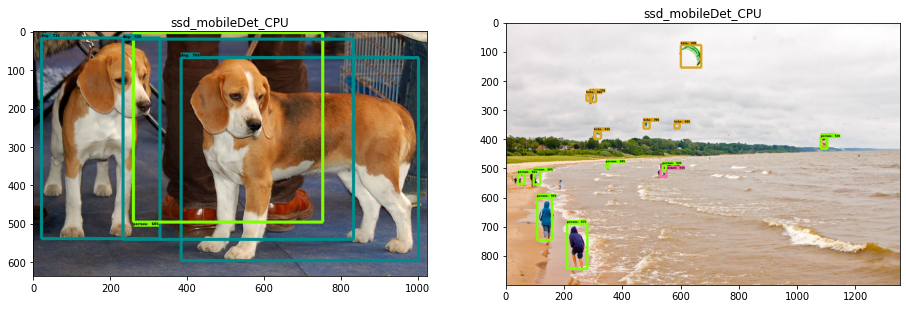

In [29]:
run_detection(os.path.join('/content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileDet_SSDLite_CPU/exported_MobileDet_CPU/frozen_inference_graph.pb'), 'ssd_mobileDet_CPU')

In [ ]:
%cd /content/drive/My Drive/ObjectDetectionAPI/MobileNet_SSDSeries/MobileDet_SSDLite_CPU

In [ ]:
!ls

In [ ]:
!zip -q -r exported_MobileDet_CPU.zip exported_MobileDet_CPU